#Vehicle Detection

##Installing and Importing Necessary Libraries

In [ ]:
!pip install tensorflow-gpu==2.0.0

In [ ]:
!pip install keras-tuner

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imutils import paths
from google.colab import drive
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook as tqdm
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score, classification_report, confusion_matrix
import random
import cv2
import os

In [5]:
filterwarnings("ignore")
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
os.chdir("/content/drive/MyDrive/Colab Notebooks")

##Data Extraction from images

In [7]:
data  = []
label = []
imagepaths = sorted(list(paths.list_images("7. Vehicle Detection using CNN [homework Project]")))
with tqdm(total=len(imagepaths)) as pbar:
    for i in imagepaths:
        try:
            image = cv2.imread(i)
            image = cv2.resize(image, (28, 28))
        except:
            continue
        data.append(img_to_array(image))
        label.append(i.split(sep="/")[1])
        pbar.update(1)

  0%|          | 0/17760 [00:00<?, ?it/s]

##EDA

In [8]:
flabels = [1 if i=="vehicles" else 0 for i in label]
check = pd.Series(flabels)
check.value_counts()

0    8968
1    8792
dtype: int64

In [9]:
np.shape(data)

(17760, 28, 28, 3)

In [10]:
flabels = np.array(flabels)
data = np.array(data, dtype = "float")

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data, flabels, random_state=10, test_size = 0.2)

##Building the Model

In [12]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters = hp.Int('conv_1_filter',min_value = 32, max_value = 128, step = 16), 
                     kernel_size = hp.Choice('conv_1_kernel', values = [3,5]),
                     activation = "relu",
                     )),
    model.add(MaxPooling2D(pool_size = (2,2), strides = (1,1)))
    model.add(Conv2D(filters = hp.Int('conv_2_filter', min_value = 32, max_value = 128, step = 16),
                     kernel_size = hp.Choice('conv_2_kernel', values = [3,5]),
                     activation = "relu")),
    model.add(MaxPooling2D(pool_size = (2,2), strides = (1,1)))
    model.add(Conv2D(filters = hp.Int('conv_3_filter', min_value = 32, max_value = 128, step = 16),
                     kernel_size = hp.Choice('conv_3_kernel', values = [3,5]),
                     activation = "relu")),
    model.add(MaxPooling2D(pool_size = (2,2), strides = (1,1)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=512, max_value=1024, step=128),activation='relu', kernel_regularizer= "l1"))
    model.add(Dense(units=hp.Int('dense_2_units', min_value=512, max_value=1024, step=128),activation='relu', kernel_regularizer= "l1"))
    model.add(Dense(units=hp.Int('dense_3_units', min_value=32, max_value=128, step=16),activation='relu', kernel_regularizer= "l1"))

    model.add(Dense(1, activation = "sigmoid"))


    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model


##Model Optimization

In [13]:
tuner_search=RandomSearch(build_model,
                          objective='accuracy', max_trials= 7, directory='output',
                          project_name="Vehicle Detection")

INFO:tensorflow:Reloading Oracle from existing project output/Vehicle Detection/oracle.json
INFO:tensorflow:Reloading Tuner from output/Vehicle Detection/tuner0.json


In [ ]:
tuner_search.search(x_train, y_train,epochs=10,validation_split=0.2)

##Building the best model

In [15]:
best_model = tuner_search.get_best_models()[0]
best_model.build(input_shape=(None,28, 28, 3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  32368     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  129152    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0

In [16]:
x_train_final, x_val, y_train_final, y_val = train_test_split(x_train, y_train, random_state = 10, test_size = 0.1, stratify= y_train)

In [17]:
x_train_final.shape

(12787, 28, 28, 3)

In [18]:
x_val.shape

(1421, 28, 28, 3)

In [19]:
y_train_final.shape

(12787,)

In [20]:
y_val.shape

(1421,)

In [21]:
Epochs = 50
M1 = best_model.fit(x = x_train_final, y = y_train_final, validation_data = (x_val, y_val), epochs= Epochs)

Train on 12787 samples, validate on 1421 samples
Epoch 1/50
12787/12787 [==============================] - 181s 14ms/sample - loss: 4.6381 - accuracy: 0.9841 - val_loss: 4.6137 - val_accuracy: 0.9838
Epoch 2/50
12787/12787 [==============================] - 180s 14ms/sample - loss: 4.5844 - accuracy: 0.9819 - val_loss: 4.7575 - val_accuracy: 0.9331
Epoch 3/50
12787/12787 [==============================] - 180s 14ms/sample - loss: 4.5480 - accuracy: 0.9803 - val_loss: 4.5997 - val_accuracy: 0.9507
Epoch 4/50
12787/12787 [==============================] - 180s 14ms/sample - loss: 4.5025 - accuracy: 0.9825 - val_loss: 4.5046 - val_accuracy: 0.9852
Epoch 5/50
12787/12787 [==============================] - 178s 14ms/sample - loss: 4.4739 - accuracy: 0.9848 - val_loss: 4.5059 - val_accuracy: 0.9873
Epoch 6/50
12787/12787 [==============================] - 177s 14ms/sample - loss: 4.4499 - accuracy: 0.9870 - val_loss: 4.4126 - val_accuracy: 0.9810
Epoch 7/50
12787/12787 [=====================

##Model Evaluation

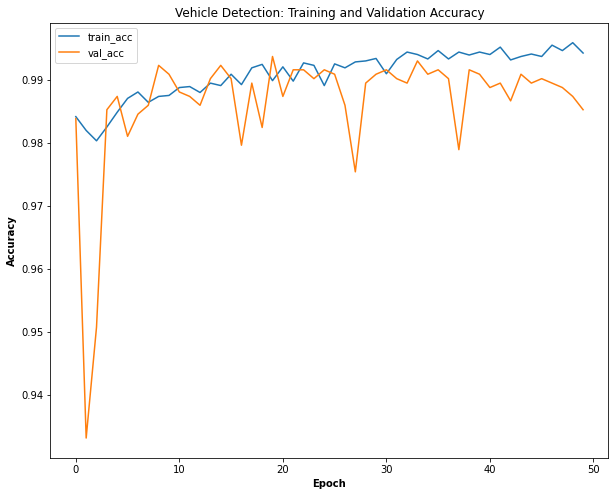

In [22]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), M1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, Epochs), M1.history["val_accuracy"], label="val_acc")
plt.title("Vehicle Detection: Training and Validation Accuracy")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

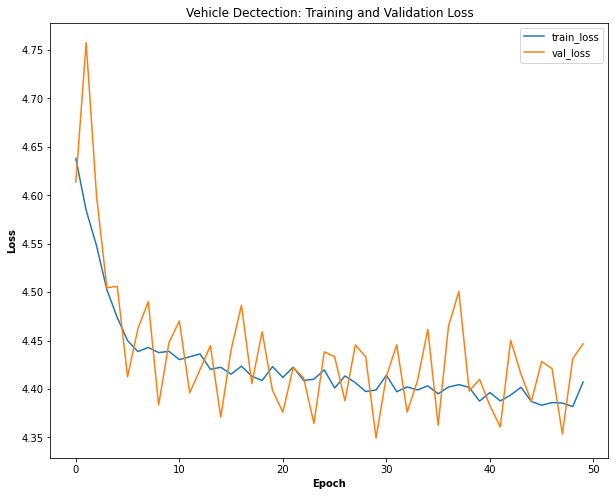

In [23]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), M1.history["loss"], label="train_loss")
plt.plot(np.arange(0, Epochs), M1.history["val_loss"], label="val_loss")
plt.title("Vehicle Dectection: Training and Validation Loss")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

In [27]:
y_pred_prob = best_model.predict(x_test)

In [37]:
def plot_roc(y_pred_prob):
    fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
    fig = plt.figure(figsize= (20,15))
    plt.plot(fpr,tpr)
    plt.plot([0,1],"r--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.text(x = 0.02, y = 0.85, s = ("AUC Score: ", roc_auc_score(y_test, y_pred_prob)))
    plt.title('ROC Curve for Vehicle Detection', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.grid(True)

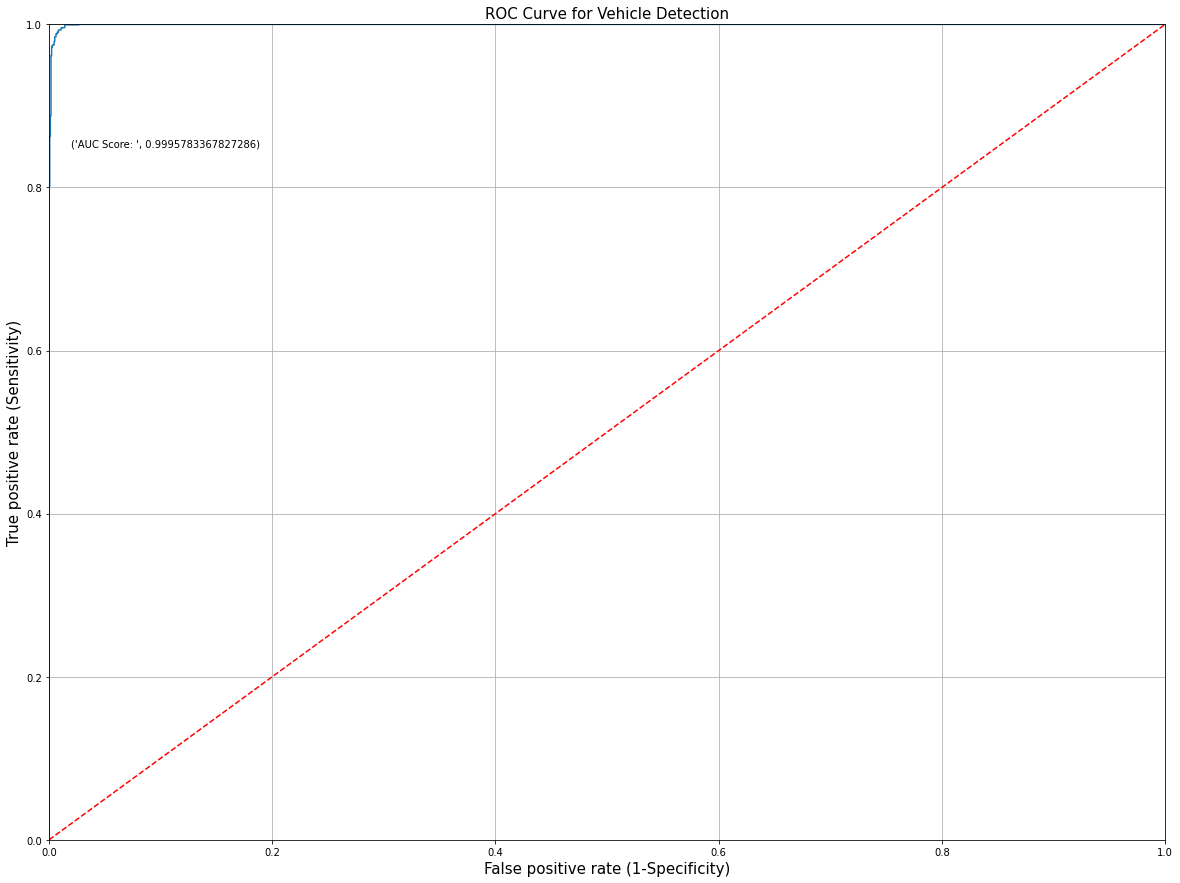

In [38]:
plot_roc(y_pred_prob)

In [39]:
y_pred = [1 if i>0.5 else 0 for i in y_pred_prob] 

In [44]:
def model_evaluation(y_test, y_pred):
    print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred), "\n")
    print("Classification Report--> \n", classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)
    sns.heatmap(cm, annot =True, fmt ="d")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")

Cohen Kappa Score: 0.9769144144144144 

Classification Report--> 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1776
           1       0.98      1.00      0.99      1776

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



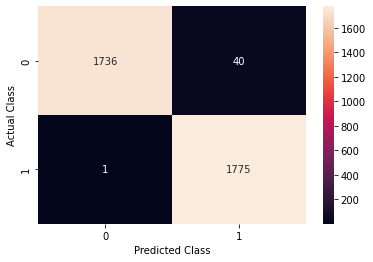

In [45]:
model_evaluation(y_test, y_pred)

##Model Deployment

In [ ]:
!pip install gradio

In [55]:
import gradio as gr
def predict_image(image):
    data_pred  = []
    image = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data_pred.append(image)
    d = np.array(data_pred, dtype = "float")
    preds = best_model.predict(d)
    if preds<0.5:
        prediction = "non-vehicle"
    else:
        prediction = "vehicle"
    
    return prediction

im = gr.inputs.Image(shape=(28,28))
label = gr.outputs.Label()

gr.Interface(fn=predict_image, inputs=im, outputs=label, capture_session=True, title="Vehicle Detection").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://32041.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f3667bbf350>,
 'http://127.0.0.1:7868/',
 'https://32041.gradio.app')